In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
from ewc import EWC
import generate_datasets as ds

c:\Users\DELL\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
# Helper function to evaluate the model
def evaluate_model(model, dataloader, device='cuda'):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    return correct / total


In [3]:
def train_model(model, train_dataloader, test_dataloaders, criterion, optimizer, ewc=None, lambda_ewc=0.0, epochs=20, device='cuda'):
    model.train()
    accuracies = np.zeros((epochs, len(test_dataloaders)))
    for epoch in range(epochs):
        total_loss = 0
        total_ewc_loss = 0
        
        for inputs, targets in train_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            task_loss = criterion(outputs, targets)

            # Add regularization loss if applicable
            ewc_loss = ewc.compute_ewc_loss(model, lambda_ewc) if ewc else 0.0
            loss = task_loss + ewc_loss

            loss.backward()
            optimizer.step()
            total_loss += task_loss.item()
            total_ewc_loss += ewc_loss

        # Evaluate the model after each epoch on each test set
        for i, test_dataloader in enumerate(test_dataloaders):
            accuracy = evaluate_model(model, test_dataloader, device)
            accuracies[epoch, i] = accuracy
            print(f"EWC loss: {total_ewc_loss / len(train_dataloader):.4f}")
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_dataloader):.4f}, Accuracy on task {i}: {accuracy:.4f}")

    return accuracies


In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load permuted datasets
permuted_train_loaders, permuted_test_loaders, _, _ = ds.load_datasets()

In [5]:
from MNIST_functions import CustomNN, EarlyStopping, set_experiment_params

# Set experiment parameters
params = set_experiment_params('2A')
learning_rate = params['learning_rate']
dropout_input = params['dropout_input']
dropout_hidden = params['dropout_hidden']
early_stopping_enabled = params['early_stopping_enabled']
num_hidden_layers = params['num_hidden_layers']
width_hidden_layers = params['width_hidden_layers']
epochs = params['epochs']

# Initialize the model, criterion, optimizer, and early stopping
model_ewc = CustomNN(num_hidden_layers=num_hidden_layers, hidden_size=width_hidden_layers, dropout_input=dropout_input, dropout_hidden=dropout_hidden).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ewc.parameters(), lr=learning_rate)
early_stopping = EarlyStopping(patience=5) if early_stopping_enabled else None

# Train on first task with EWC
ewc = EWC(model_ewc)
accuracies_a = train_model(model_ewc, permuted_train_loaders[0], permuted_test_loaders[0:1], criterion, optimizer, ewc=ewc, lambda_ewc=40000, epochs=epochs, device=device)

ewc.compute_fisher(permuted_train_loaders[0])
ewc.update_params()

# Train on second task with EWC
accuracies_b = train_model(model_ewc, permuted_train_loaders[1], permuted_test_loaders[0:2], criterion, optimizer, ewc=ewc, lambda_ewc=40000, epochs=epochs, device=device)

ewc.compute_fisher(permuted_train_loaders[1])
ewc.update_params()

# Train on third task with EWC
accuracies_c = train_model(model_ewc, permuted_train_loaders[2], permuted_test_loaders[0:3], criterion, optimizer, ewc=ewc, lambda_ewc=40000, epochs=epochs, device=device)


EWC loss: 0.0000
Epoch 1/20, Loss: 0.4072, Accuracy on task 0: 0.9397
EWC loss: 0.0000
Epoch 2/20, Loss: 0.1402, Accuracy on task 0: 0.9517
EWC loss: 0.0000
Epoch 3/20, Loss: 0.0950, Accuracy on task 0: 0.9609
EWC loss: 0.0000
Epoch 4/20, Loss: 0.0684, Accuracy on task 0: 0.9637
EWC loss: 0.0000
Epoch 5/20, Loss: 0.0523, Accuracy on task 0: 0.9662
EWC loss: 0.0000
Epoch 6/20, Loss: 0.0400, Accuracy on task 0: 0.9678
EWC loss: 0.0000
Epoch 7/20, Loss: 0.0314, Accuracy on task 0: 0.9658
EWC loss: 0.0000
Epoch 8/20, Loss: 0.0250, Accuracy on task 0: 0.9695
EWC loss: 0.0000
Epoch 9/20, Loss: 0.0198, Accuracy on task 0: 0.9705
EWC loss: 0.0000
Epoch 10/20, Loss: 0.0163, Accuracy on task 0: 0.9683
EWC loss: 0.0000
Epoch 11/20, Loss: 0.0131, Accuracy on task 0: 0.9711
EWC loss: 0.0000
Epoch 12/20, Loss: 0.0110, Accuracy on task 0: 0.9701
EWC loss: 0.0000
Epoch 13/20, Loss: 0.0094, Accuracy on task 0: 0.9714
EWC loss: 0.0000
Epoch 14/20, Loss: 0.0080, Accuracy on task 0: 0.9713
EWC loss: 0.000

In [7]:
# evaluate on all tasks
acc_a_ewc = evaluate_model(model_ewc, permuted_test_loaders[0], device=device)
acc_b_ewc = evaluate_model(model_ewc, permuted_test_loaders[1], device=device)
acc_c_ewc = evaluate_model(model_ewc, permuted_test_loaders[2], device=device)

print(f"EWC - Accuracy on Task A: {acc_a_ewc:.2f}, Task B: {acc_b_ewc:.2f}, Task C: {acc_c_ewc:.2f}")

EWC - Accuracy on Task A: 0.97, Task B: 0.96, Task C: 0.95


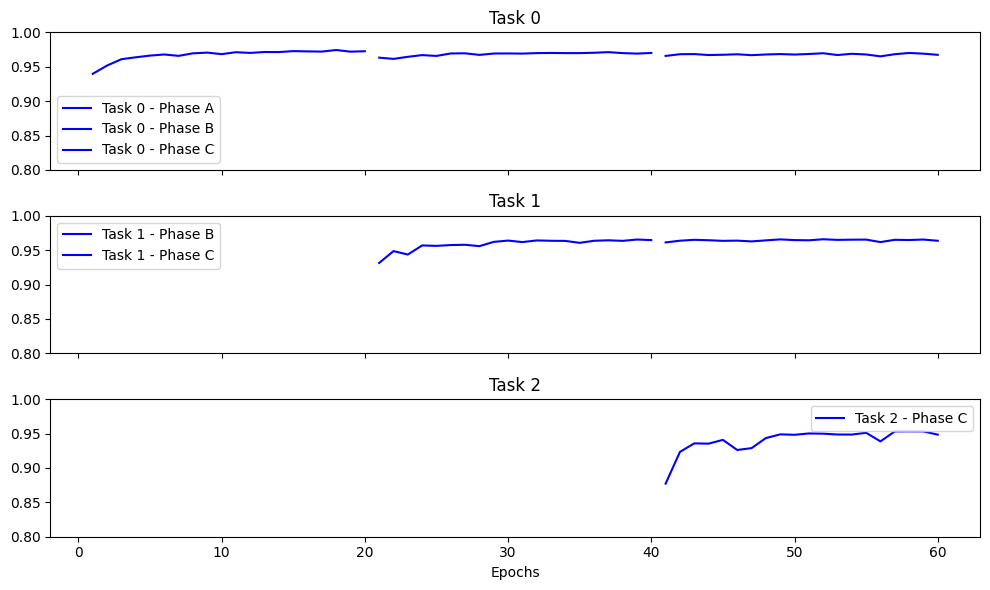

In [6]:
# plot separately accuracies on task 0, 1, 2
# task 0 is present in accuracies_a, accuracies_b, accuracies_c; task 1 is present in accuracies_b, accuracies_c; task 2 is present in accuracies_c
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
# Plot accuracies for Task 0
axes[0].plot(np.arange(1, epochs + 1), accuracies_a[:, 0], label='Task 0 - Phase A', color='blue')
axes[0].plot(np.arange(epochs + 1, 2 * epochs + 1), accuracies_b[:, 0], label='Task 0 - Phase B', color='blue')
axes[0].plot(np.arange(2 * epochs + 1, 3 * epochs + 1), accuracies_c[:, 0], label='Task 0 - Phase C', color='blue')
axes[0].set_title('Task 0')
axes[0].legend()
axes[0].set_ylim(0.8, 1.0)

# Plot accuracies for Task 1
axes[1].plot(np.arange(epochs + 1, 2 * epochs + 1), accuracies_b[:, 1], label='Task 1 - Phase B', color='blue')
axes[1].plot(np.arange(2 * epochs + 1, 3 * epochs + 1), accuracies_c[:, 1], label='Task 1 - Phase C', color='blue')
axes[1].set_title('Task 1')
axes[1].legend()
axes[1].set_ylim(0.8, 1.0)

# Plot accuracies for Task 2
axes[2].plot(np.arange(2 * epochs + 1, 3 * epochs + 1), accuracies_c[:, 2], label='Task 2 - Phase C', color='blue')
axes[2].set_title('Task 2')
axes[2].legend()
axes[2].set_ylim(0.8, 1.0)

# Set common labels
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()


In [23]:
# save accuracies
# np.save('results/accuracies_a_ewc.npy', accuracies_a)
# np.save('results/accuracies_b_ewc.npy', accuracies_b)
# np.save('results/accuracies_c_ewc.npy', accuracies_c)